In [1]:
%matplotlib inline

import numpy as np
import torch
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from src.utils import ratemap_collage, weighted_kde, SimpleDatasetMaker
from src.models import RecurrentSpaceNet, Decoder, End2End

#plt.style.use("figures/project_style.mplstyle")

In [43]:
## Training parameters
train_steps = 5000

n_in = 2                # Cartesian coordinates, no context
n_out = 100             # no. of spatial representations
scale = 0.15            # scale of spatial representations
long_timesteps = 3000   # length of long trajectory
timesteps = 300         # length of trajectory
bs = 64                 # batch size
lr = 1e-4               # learning rate

In [44]:
# Prepare model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in=n_in, n_out=n_out, corr_across_space=False, scale=scale, device=device, stateful=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

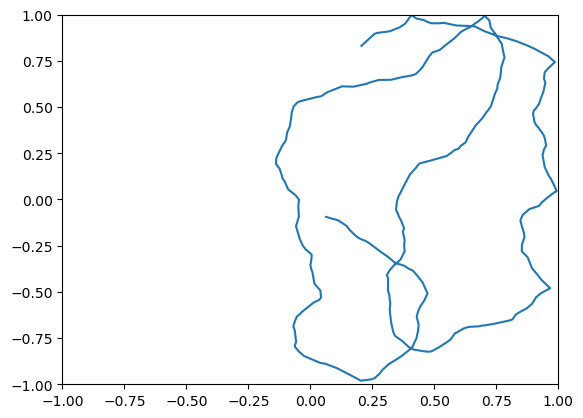

In [45]:
genny = SimpleDatasetMaker()
r, v = genny.generate_dataset(1, timesteps)
plt.plot(*r.detach().numpy().T)
plt.axis([-1, 1, -1, 1])
plt.show()

In [46]:
def slice_trajectories(trajectories, slice_length):
    num_slices = trajectories.shape[1] // slice_length
    return [trajectories[:, i * slice_length: (i + 1) * slice_length] for i in range(num_slices)]

In [47]:
loss_history = []
progress = tqdm(range(train_steps))

for i in progress:

    # Reset the hidden state after processing each long trajectory
    hidden_state = None

    # Generate long trajectory
    long_r, long_v = genny.generate_dataset(bs, long_timesteps, device=device)

    # Slice the long trajectory into sub-trajectories
    sub_trajectories_r = slice_trajectories(long_r[:, 1:], timesteps)
    sub_trajectories_v = slice_trajectories(long_v, timesteps)

    for r, v in zip(sub_trajectories_r, sub_trajectories_v):

        # Reset optimizer
        optimizer.zero_grad()

        # Call loss function
        loss, hidden_state = model.loss_fn((v, r[:, 0]), r, hidden_state)
        # loss, hidden_state = model.loss_fn(v, r, hidden_state)

        loss.backward()
        optimizer.step()
        loss = loss.item()

        # Detach the hidden state from the graph
        hidden_state = hidden_state.detach()

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")


loss: 0.031249: 100%|██████████| 5000/5000 [1:22:38<00:00,  1.01it/s]


Text(0, 0.5, 'Train Loss')

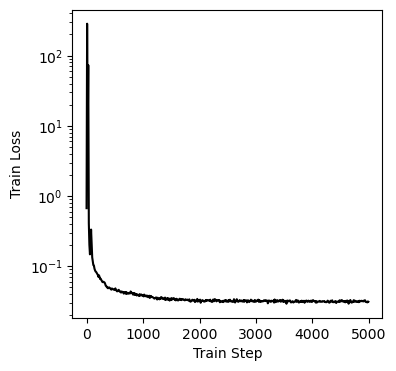

In [48]:
plt.figure(figsize=(4,4))
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k")
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

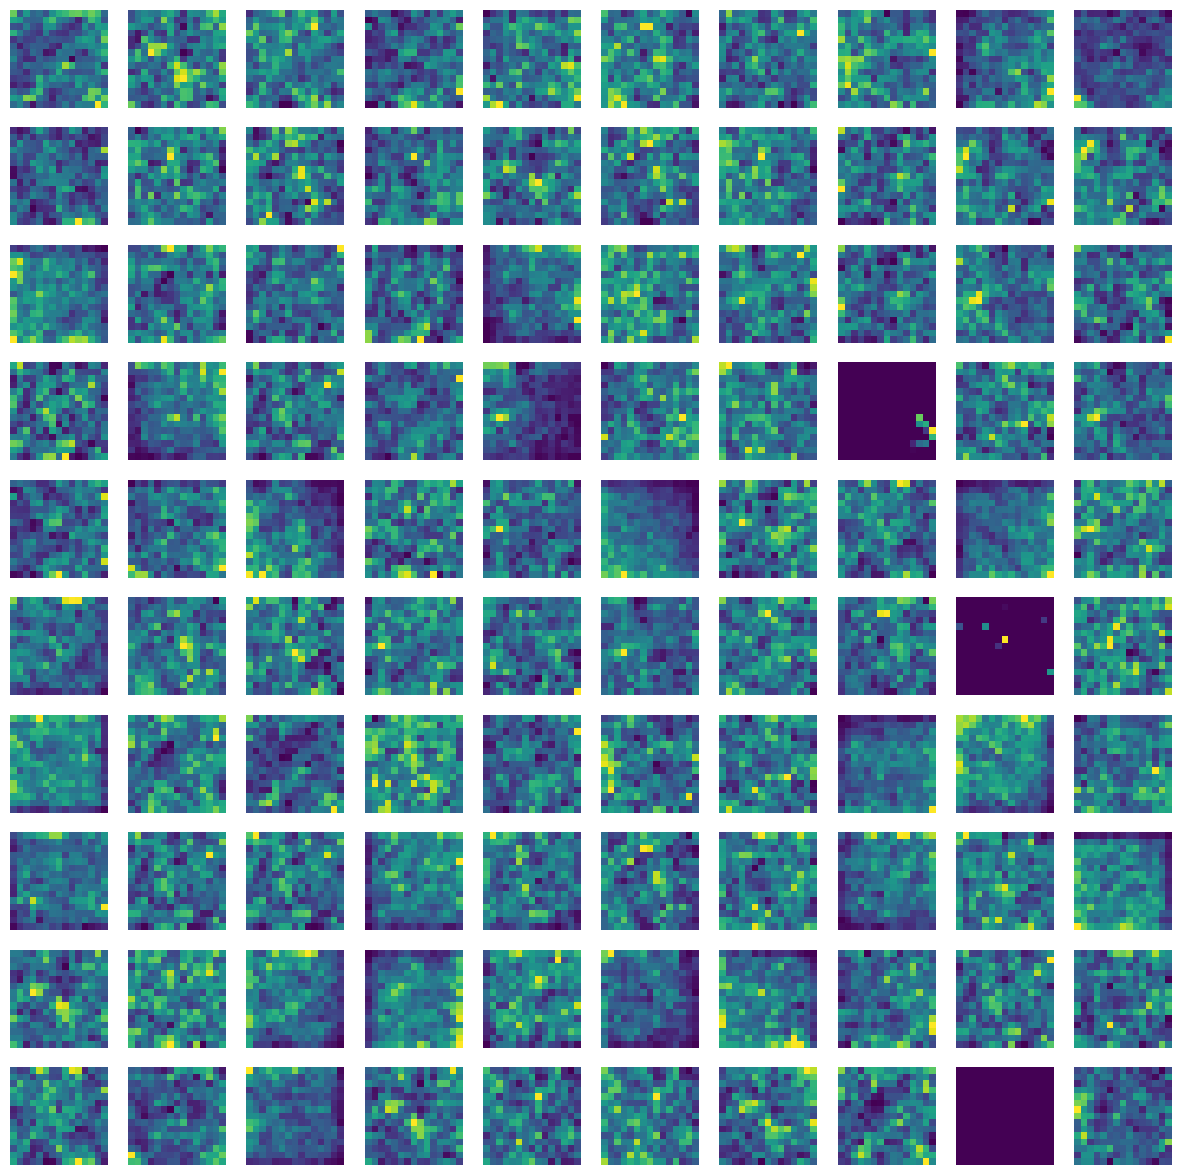

In [50]:
# visualize representations
n_plot = 1       # number of plot trajectories
n_show = 100        # number of units to show
timesteps = 100000     # length of trajectory
r, v = genny.generate_dataset(n_plot, timesteps)

# BSR
initial = model.initial_state(v.shape[0])
p, hidden_state = model.spatial_representation(v, initial)
p = p.detach().numpy()
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins=15)
fig, ax = ratemap_collage(ratemaps[:n_show], cols=int(np.sqrt(n_show)), figsize=(15, 15))

In [21]:
p.shape

(1, 99999, 100)

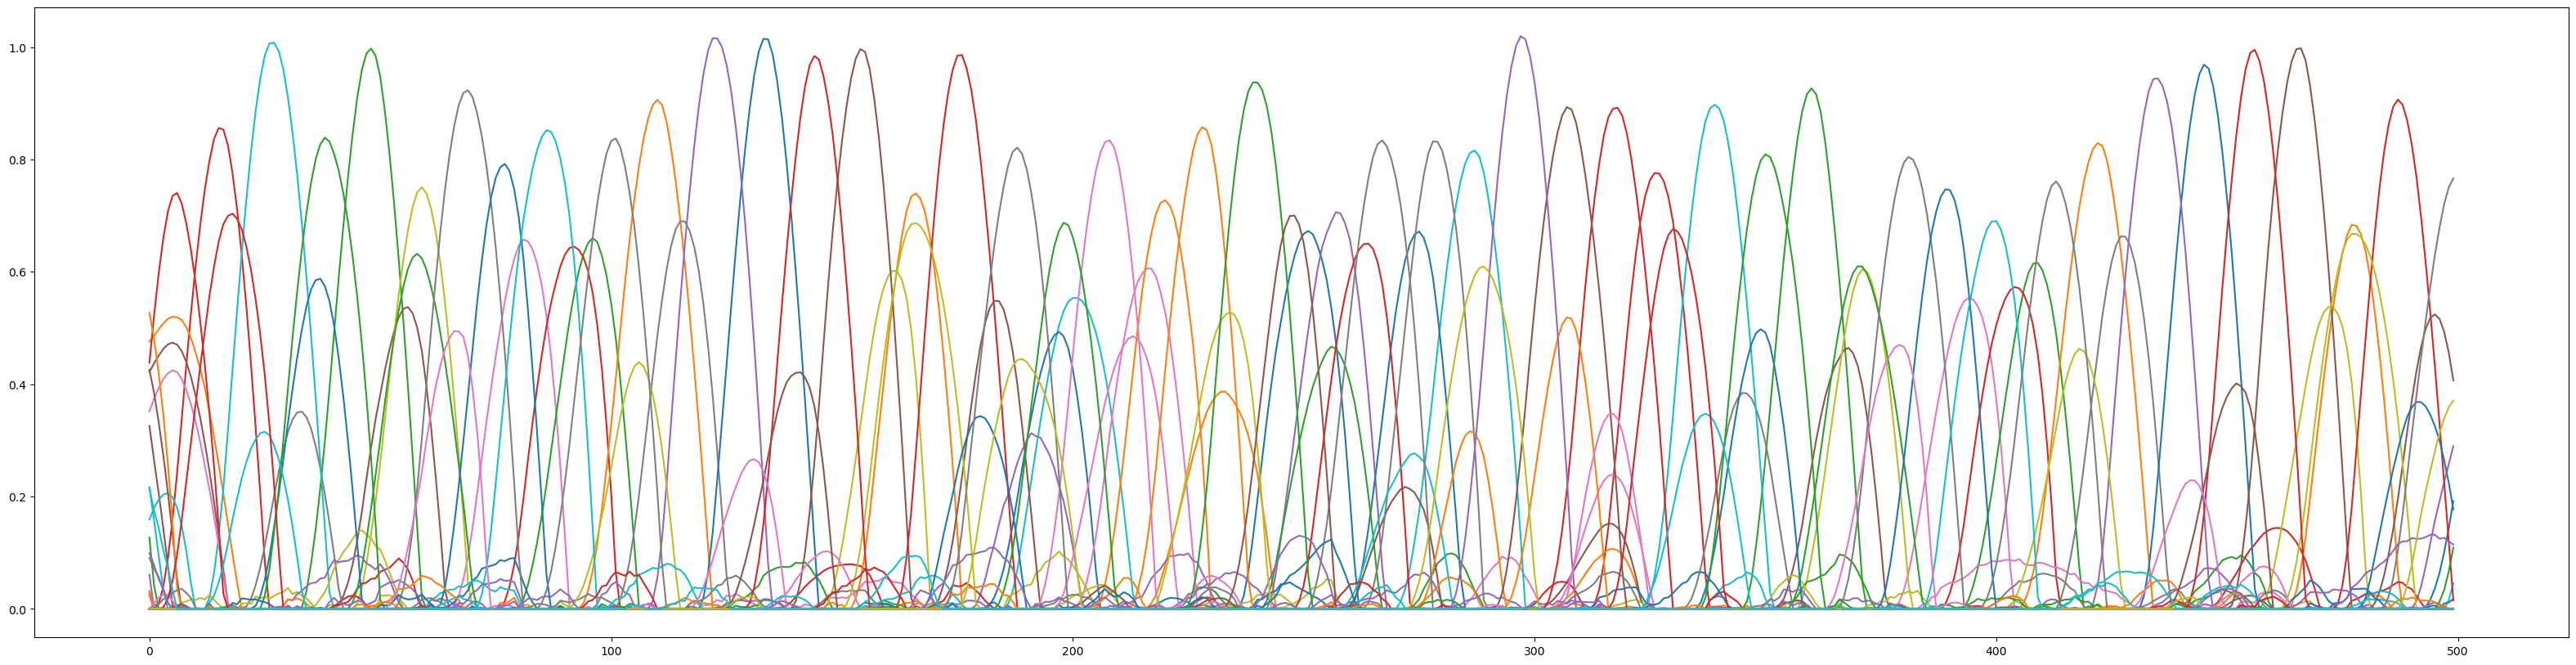

In [24]:
fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(p[0, :500, :])

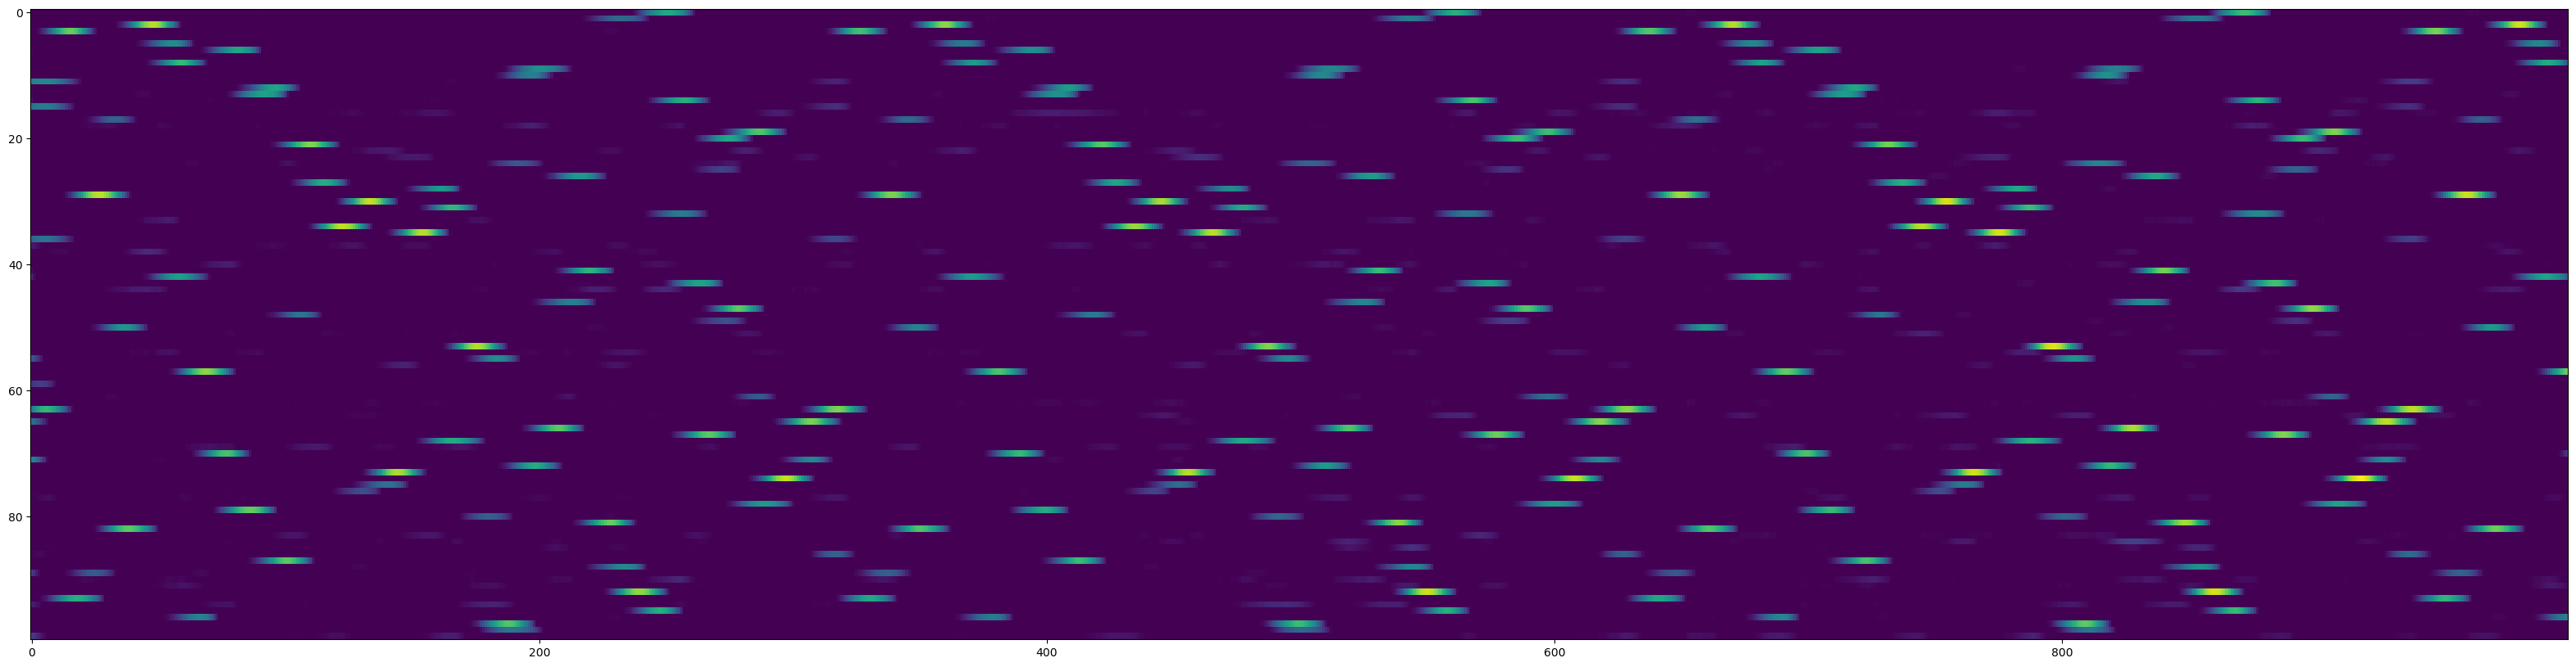

In [27]:
fig, ax = plt.subplots(figsize=(40, 10))
ax.imshow(p[0, :1000, :].T, aspect='auto', interpolation='none')

Can we decode activity from the spatial representations?